# Twitter 1.6 million tweets Sentiment Analysis

The Sentiment140 dataset is an excellent resource for those interested in performing sentiment analysis of Twitter data. It contains 1.6 million tweets pre-classified as either positive or negative. This dataset is well suited to machine learning approaches as it contains a large number of easily accessible features, such as tweet text, user profile information, and sentiment. The challenge associated with this dataset is that the tweets can be full of slang, abbreviations, and other language features that are difficult for machines to interpret.


Each tweet in the dataset has several features, including the following:

target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

ids: The id of the tweet ( 2087)

date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

flag: The query (lyx). If there is no query, then this value is NO_QUERY.

user: the user that tweeted (robotickilldozr)

text: the text of the tweet (Lyx is cool)


We will use supervised and unsupervised learning methods to evaluate this dataset based on various machine learning theories. In particular, we will explore how well these models can predict the sentiment label of each tweet based on its text. We will also examine various NLP techniques that can be used to preprocess the text data and improve the performance of our models.

Overall, this dataset provides an excellent opportunity to explore the application of NLP methods to real-world data. By analyzing this data, we can gain insights into how people express sentiment on social media and develop models that can accurately classify the sentiment of new tweets.



In [34]:
# Import the Necessary Dependencies

# Data Manipulation
import re ## regular expression operator
import numpy as np
import pandas as pd
import string 


# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Methods and stopwords text processing
import nltk ## natural language toolkit
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer


# Machine Learning Libraries
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split




In [35]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df_raw = pd.read_csv('twitter_data.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

#Exploratory Data Analysis
df_raw.head()

# Removing the unnecessary columns.
df_raw = df_raw[['target','text']]

# Storing data in lists.
text, target = list(df_raw['text']), list(df_raw['target'])

In [36]:
print('length of data is', len(df_raw))


length of data is 1600000


In [37]:

# Create subgroups based on the target column
subgroups = df_raw['target'].astype(str)  # Convert the 'target' column to a string to ensure correct stratification

# Specify the number of tweets you want to include in your final dataset for each subgroup
n_samples = 20000  # Replace with the desired number of tweets in each subgroup

# Use train_test_split to do stratified sampling
target0_df, _ = train_test_split(df_raw[subgroups == '0'], stratify=subgroups[subgroups == '0'], train_size=n_samples/len(df_raw[subgroups == '0']), random_state=42)
target4_df, _ = train_test_split(df_raw[subgroups == '4'], stratify=subgroups[subgroups == '4'], train_size=n_samples/len(df_raw[subgroups == '4']), random_state=42)

# Combine the two subgroups into a single dataframe
df = pd.concat([target0_df, target4_df], ignore_index=True)

# Save the sampled dataset
df.to_csv('sampled_twitter_data.csv', index=False)

In [38]:
print('The new length of data is', len(df))


The new length of data is 40000


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  40000 non-null  int64 
 1   text    40000 non-null  object
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [40]:
df.dtypes

target     int64
text      object
dtype: object

In [41]:
#Checking for null values
np.sum(df.isnull().any(axis=1))

0

In [42]:
#Rows and columns in the dataset
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   2
Count of rows in the data is:   40000


In [43]:
#Check unique target values
df['target'].unique()

array([0, 4], dtype=int64)

In [44]:
#Check the number of target values
df['target'].nunique()

2

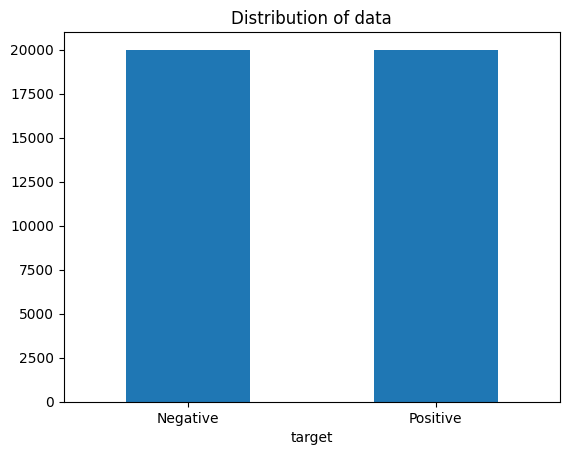

In [45]:
# Data Visualization of Target Variables

# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

<Axes: xlabel='target', ylabel='count'>

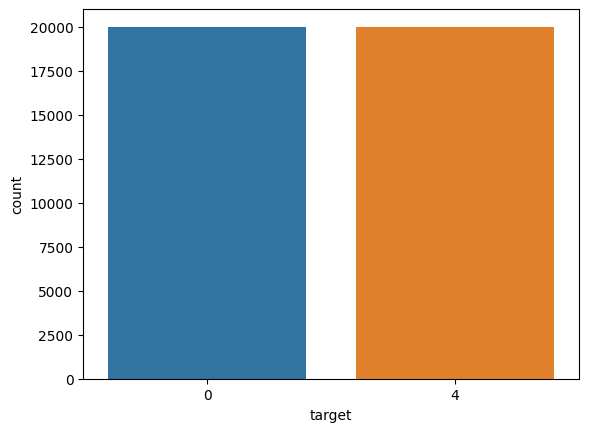

In [46]:
sns.countplot(x='target', data=df)

In [47]:
df['text'].tail()

39995    @Dan_Jones there is always something to be pay...
39996    a cool day on the bay today, light winds and a...
39997    Voting is over, Conservatives strongest, Socia...
39998    Justback from Jason's house.  Very nice lots o...
39999    is chatting on facey with @JuliaBier and Matt ...
Name: text, dtype: object

In [48]:
# Convert all text to lowercase
df['text'] = df['text'].str.lower()
df['text'].tail()

39995    @dan_jones there is always something to be pay...
39996    a cool day on the bay today, light winds and a...
39997    voting is over, conservatives strongest, socia...
39998    justback from jason's house.  very nice lots o...
39999    is chatting on facey with @juliabier and matt ...
Name: text, dtype: object

In [49]:
#Cleaning and removing punctuations

english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
df['text']= df['text'].apply(lambda x: cleaning_punctuations(x))
df['text'].tail()

39995    danjones there is always something to be pay f...
39996    a cool day on the bay today light winds and a ...
39997    voting is over conservatives strongest sociali...
39998    justback from jasons house  very nice lots of ...
39999    is chatting on facey with juliabier and matt a...
Name: text, dtype: object

In [50]:
#Cleaning and removing repeating characters

def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
df['text'] = df['text'].apply(lambda x: cleaning_repeating_char(x))
df['text'].tail()

39995    danjones there is always something to be pay f...
39996    a cool day on the bay today light winds and a ...
39997    voting is over conservatives strongest sociali...
39998    justback from jasons house  very nice lots of ...
39999    is chatting on facey with juliabier and matt a...
Name: text, dtype: object

In [51]:
#Cleaning and removing URLs

def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
df['text'] = df['text'].apply(lambda x: cleaning_URLs(x))
df['text'].tail()

39995    danjones there is always something to be pay f...
39996    a cool day on the bay today light winds and a ...
39997    voting is over conservatives strongest sociali...
39998    justback from jasons house  very nice lots of ...
39999    is chatting on facey with juliabier and matt a...
Name: text, dtype: object

In [52]:
#Cleaning and removing numeric numbers

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
df['text'] = df['text'].apply(lambda x: cleaning_numbers(x))
df['text'].tail()

39995    danjones there is always something to be pay f...
39996    a cool day on the bay today light winds and a ...
39997    voting is over conservatives strongest sociali...
39998    justback from jasons house  very nice lots of ...
39999    is chatting on facey with juliabier and matt a...
Name: text, dtype: object

In [53]:
# Removing # and @ characters from tweets and other symbols

def cleaning_characters(data):
    return re.sub(r'\@\w+|\#|\'|\"|\´|\`|\,','', data)
df['text'] = df['text'].apply(lambda x: cleaning_characters(x))
df['text'].tail()


39995    danjones there is always something to be pay f...
39996    a cool day on the bay today light winds and a ...
39997    voting is over conservatives strongest sociali...
39998    justback from jasons house  very nice lots of ...
39999    is chatting on facey with juliabier and matt a...
Name: text, dtype: object

In [54]:
#Defining set containing all stopwords in English.

nltk.download ('stopwords')
stop_words = set(stopwords.words( 'english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Thamires\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
#Cleaning and removing the above stop words list from the tweet text

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
df['text'] = df['text'].apply(lambda text: cleaning_stopwords(text))
df['text'].tail()


39995    danjones always something pay good news though...
39996    cool day bay today light winds showers time pu...
39997    voting conservatives strongest socialists weak...
39998                 justback jasons house nice lots work
39999                  chatting facey juliabier matt maine
Name: text, dtype: object

In [56]:
# Count the words used per user

def word_count(sentence):
    return len(sentence.split())
    
df['word count'] = df['text'].apply(word_count)
df.tail()

,target,text,word count
39995,4,danjones always something pay good news though...,16
39996,4,cool day bay today light winds showers time pu...,16
39997,4,voting conservatives strongest socialists weak...,14
39998,4,justback jasons house nice lots work,6
39999,4,chatting facey juliabier matt maine,5


In [57]:
# Stemming process

st = nltk.PorterStemmer()
def stemming_process(data):
    text = [st.stem(word) for word in data]
    return data
df['text']= df['text'].apply(lambda x: stemming_process(x))
df['text'].tail()



39995    danjones always something pay good news though...
39996    cool day bay today light winds showers time pu...
39997    voting conservatives strongest socialists weak...
39998                 justback jasons house nice lots work
39999                  chatting facey juliabier matt maine
Name: text, dtype: object

In [58]:
# Lemmatizer Proccess

lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
df['text'] = df['text'].apply(lambda x: lemmatizer_on_text(x))
df['text'].tail()

39995    danjones always something pay good news though...
39996    cool day bay today light winds showers time pu...
39997    voting conservatives strongest socialists weak...
39998                 justback jasons house nice lots work
39999                  chatting facey juliabier matt maine
Name: text, dtype: object

In [59]:
# Separating positive and negative tweets

data_pos = df[df['target'] == 4]
data_neg = df[df['target'] == 0]
df = pd.concat([data_neg, data_pos])
data_neg.tail()

# Save the sampled dataset
df.to_csv('sampled_twitter_data.csv', index=False)


In [60]:
data_pos.tail()

,target,text,word count
39995,4,danjones always something pay good news though...,16
39996,4,cool day bay today light winds showers time pu...,16
39997,4,voting conservatives strongest socialists weak...,14
39998,4,justback jasons house nice lots work,6
39999,4,chatting facey juliabier matt maine,5


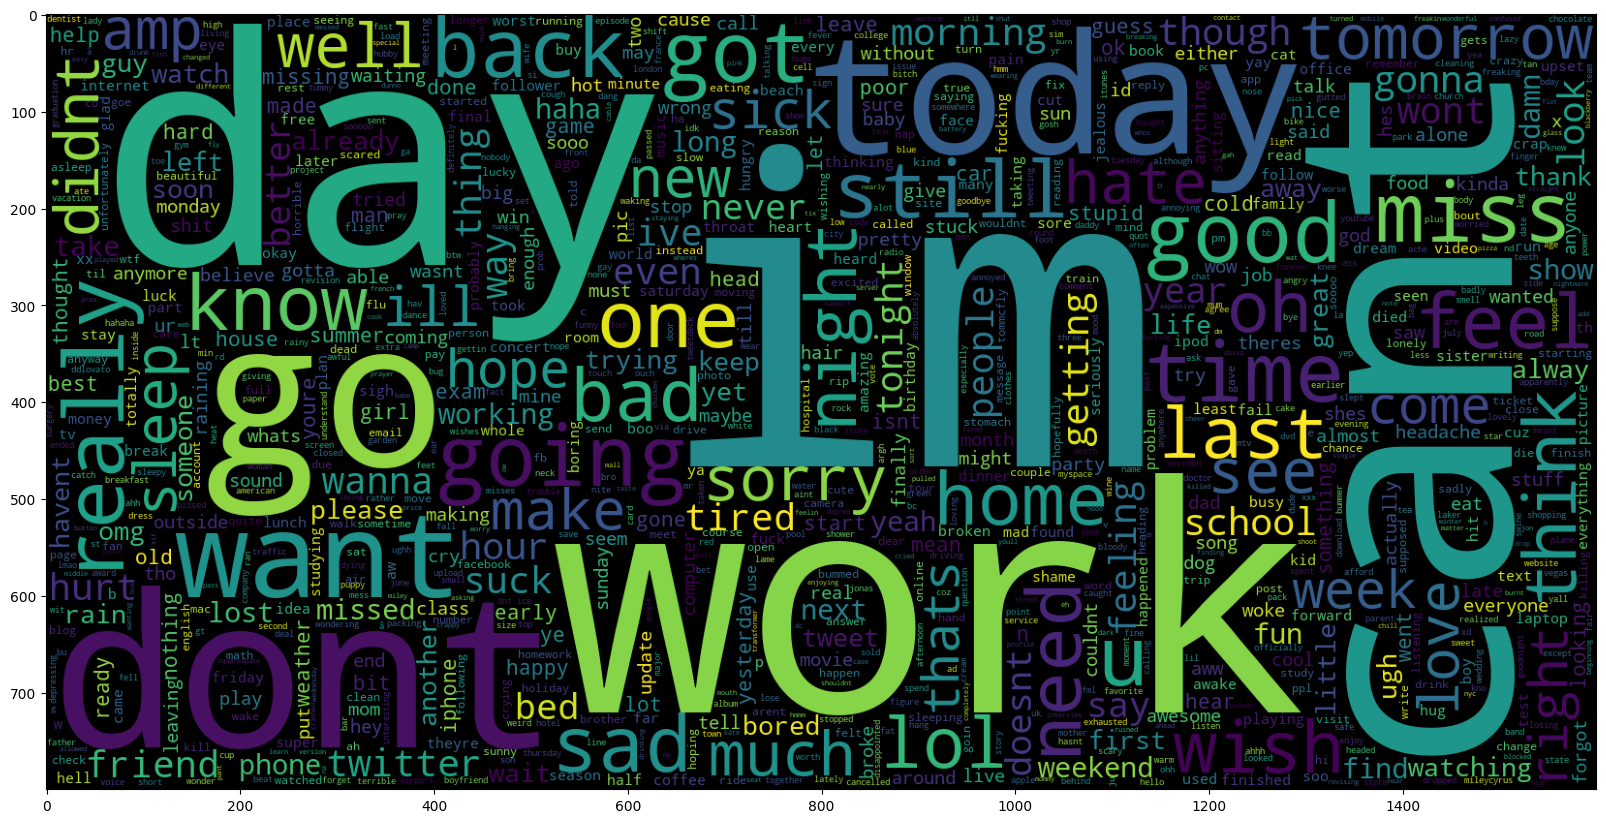

In [61]:
# Plot words of negative tweets

data_neg1 = df['text'][:20000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(map(str,data_neg1)))
plt.imshow(wc)

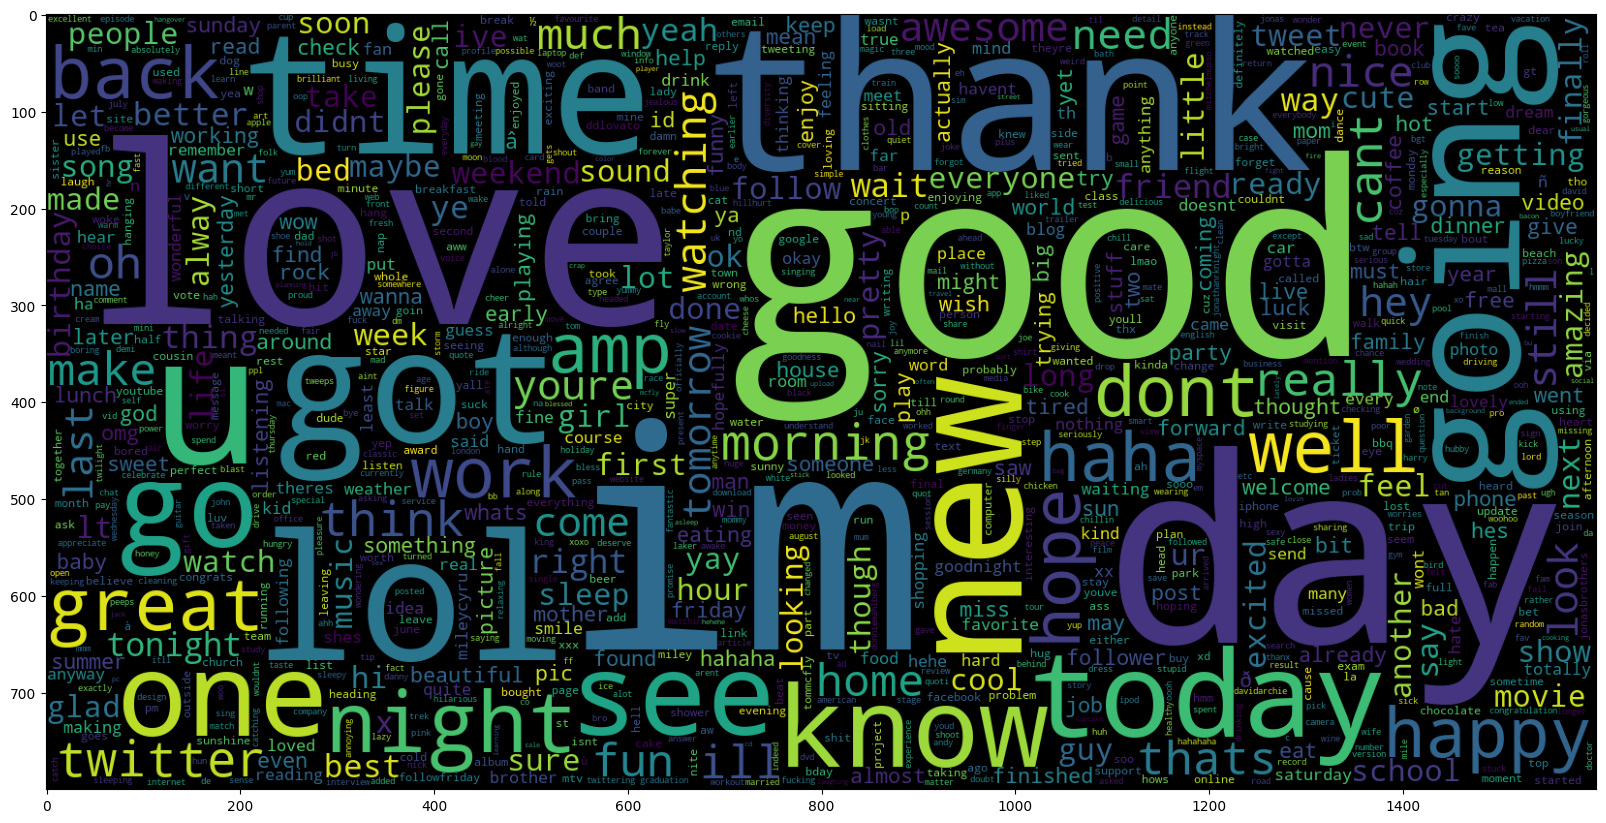

In [62]:
# Plot tweets of positive tweets

data_pos1 = df['text'][20000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(map(str, data_pos1)))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [72]:
# Doing tokenization of Tweet Text

tokenizer = RegexpTokenizer(r'\w+')
df_tk = df['text'].apply(tokenizer.tokenize)
df_tk.tail()

39995    [danjones, always, something, pay, good, news,...
39996    [cool, day, bay, today, light, winds, showers,...
39997    [voting, conservatives, strongest, socialists,...
39998          [justback, jasons, house, nice, lots, work]
39999            [chatting, facey, juliabier, matt, maine]
Name: text, dtype: object

In [73]:
# Separate the date into train and test subset

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'],
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

# X = df.drop('target', axis=1)  # Predictor feature columns
# y = df['target']   # Predicted class (1=True, 0=False)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=0) 
# 0.05 is the proportion of the data to allocate to the test set 
#the random seed used to split the data. This ensures that the same random split is used every time the code is run.

X_train.tail()

X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)



Data Split done.


In [74]:
print(('X_train shape =', X_train.shape), ('y_train shape =', y_train.shape), ('X_test shape =', X_test.shape), ('y_test shape =', y_test.shape))

('X_train shape =', (38000,)) ('y_train shape =', (38000,)) ('X_test shape =', (2000,)) ('y_test shape =', (2000,))


## code explanation

This code is trying to balance the number of samples in the two classes (majority and minority) in a dataset. The dataset has features (X_train) and targets (y_train), where y_train=0 represents the majority class and y_train=4 represents the minority class.

To balance the dataset, the code first separates the majority and minority classes based on their target values. The majority class features are stored in a variable called X_majority, and the minority class features are stored in a variable called X_minority.

Next, the majority class is undersampled by selecting the same number of samples as there are in the minority class. This is done using the resample() function with the following parameters: X_majority (features of majority class), replace=False (no replacement), n_samples=len(X_minority) (selecting the same number of samples as minority class), and random_state=42 (for reproducibility).

Finally, the downsampled majority class and the minority class are combined to create a balanced training dataset. This is done by concatenating the downsampled majority class and minority class features and targets using the numpy concatenate() function. The target values for the downsampled majority class are set to 0 (majority class) using np.zeros() function, and the target values for the minority class are set to 4 (minority class) using np.ones() function. The balanced features and targets are stored in X_train_balanced and y_train_balanced variables, respectively.

You can set any integer value for random_state. The choice of the specific number, in this case, 42, is arbitrary.

The number 42 is sometimes used in computer science and related fields as a "random" number. It is a reference to the book "The Hitchhiker's Guide to the Galaxy" by Douglas Adams, in which the number 42 is famously described as the "Answer to the Ultimate Question of Life, the Universe, and Everything."

In reality, there is nothing special about the number 42, and any other integer value can be used instead. The important thing is to use a fixed value for random_state in order to achieve reproducibility.

# TF-IDF Vectoriser

TF-IDF indicates what the importance of the word is in order to understand the document or dataset. Let us understand with an example. Suppose you have a dataset where students write an essay on the topic, My House. In this dataset, the word a appears many times; it’s a high frequency word compared to other words in the dataset. The dataset contains other words like home, house, rooms and so on that appear less often, so their frequency are lower and they carry more information compared to the word. This is the intuition behind TF-IDF.

TF-IDF Vectoriser converts a collection of raw documents to a matrix of TF-IDF features. The Vectoriser is usually trained on only the X_train dataset.

ngram_range is the range of number of words in a sequence. [e.g "very expensive" is a 2-gram that is considered as an extra feature separately from "very" and "expensive" when you have a n-gram range of (1,2)]

max_features specifies the number of features to consider. [Ordered by feature frequency across the corpus].

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

# # vectorize the text data
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)
print('Vectorizer fitted.')
print('No. of feature_words: ', len(vectorizer.get_feature_names_out()))

# # transform the text data into a sparse matrix
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# save it into sparse matrix format
# save_npz('X_train.npz', X_train_vec) #model do save sparse matrix
# save_npz('X_test.npz', X_test_vec)

Vectorizer fitted.
No. of feature_words:  248833


In [ ]:
# # train the Bernoulli Naive Bayes model
# clf = BernoulliNB()
# clf.fit(X_train_vec, y_train)

# # make predictions on the test data
# y_pred = clf.predict(X_test_vec)

# # calculate the accuracy score
# accuracy = accuracy_score(y_test, y_pred)
# print('Accuracy: {:.2f}%'.format(accuracy*100))

Accuracy: 75.35%


In [ ]:
# Evaluate Model Function

def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test_vec)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.74      0.77      0.76       983
           4       0.77      0.74      0.76      1017

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000



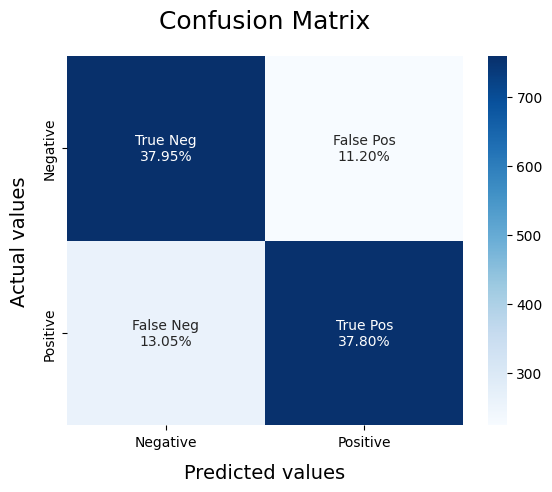

In [70]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train_vec, y_train)
model_Evaluate(BNBmodel)

In [ ]:
# print(X_test)

# For this result:

# (0, 3) 1.0
# (1, 1) 1.0
# (2, 2) 1.0
# (3, 5) 1.0
# (4, 4) 1.0
# (5, 7) 0.5773502691896257
# (5, 6) 0.5773502691896257
# (5, 0) 0.5773502691896257

# It represents a sparse matrix in compressed sparse row format (CSR). The numbers inside the parentheses represent the coordinates of the non-zero elements in the matrix. The first number is the row index, and the second number is the column index. The number after the comma is the value of the non-zero element.

# In this specific case, we have a 6x8 matrix where the non-zero values are:

# (0, 3): 1.0
# (1, 1): 1.0
# (2, 2): 1.0
# (3, 5): 1.0
# (4, 4): 1.0
# (5, 7): 0.5773502691896257
# (5, 6): 0.5773502691896257
# (5, 0): 0.5773502691896257

# O resultado que você obteve após aplicar a transformação com o TfidfVectorizer é uma matriz esparsa. Matrizes esparsas são matrizes que contêm principalmente zeros e alguns valores não nulos. No seu caso, cada linha da matriz representa um documento e cada coluna representa uma palavra-chave (também chamada de recurso ou feature). Os valores não nulos indicam a frequência de cada palavra-chave em cada documento, ponderada pelo esquema TF-IDF.

# O esquema TF-IDF (Term Frequency-Inverse Document Frequency) é uma medida estatística usada para avaliar a importância de uma palavra-chave em um documento, em relação a uma coleção de documentos. A frequência do termo (TF) mede quantas vezes a palavra-chave aparece no documento, enquanto a frequência inversa do documento (IDF) mede o quão raro é a palavra-chave na coleção de documentos. O produto TF-IDF pondera a importância da palavra-chave em um determinado documento e ajuda a reduzir a importância de palavras-chave comuns.

# Ao utilizar o TfidfVectorizer, você gerou um modelo de vetorização que calcula a frequência de cada palavra-chave em cada documento, ponderada pelo esquema TF-IDF. Esse modelo é então usado para transformar seus dados de treinamento e teste em matrizes esparsas com valores TF-IDF. O número de colunas (palavras-chave) é limitado pelo parâmetro max_features, que define o número máximo de recursos usados no modelo. O n-gram_range especifica os tamanhos dos n-gramas usados na vetorização, neste caso, de 1 a 2 palavras.

# Espero que essa explicação tenha ajudado a esclarecer o que significa a matriz esparsa resultante da transformação com o TfidfVectorizer.


# Esses números representam uma matriz esparsa de um conjunto de dados transformado pelo TfidfVectorizer.

# Cada linha dessa matriz representa um documento (ou amostra) do conjunto de dados, e cada coluna representa uma palavra ou combinação de palavras (dependendo do valor definido para o parâmetro ngram_range) que foram extraídas do texto.

# Os números nos parênteses indicam a linha, a coluna e o valor associado. Por exemplo, na primeira linha, quarta coluna, temos o valor 1.0, o que significa que a quarta palavra (ou combinação de palavras) da lista de recursos está presente no primeiro documento com um valor tf-idf (frequência de termo–inverso da frequência de documento) de 1.0.

# Já na última linha, temos vários valores, indicando que a amostra correspondente (quinta amostra, já que a indexação começa em zero) contém várias palavras (ou combinações de palavras) diferentes com diferentes valores tf-idf.